In [1]:
# IMPORTS


import os
import random
import re
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import feature, io, color
from skimage.feature import hog
from skimage.filters import sobel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading CSV data


styles_df = pd.read_csv('styles.csv')

# Display the first few rows of the dataset
styles_df.head(10)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
5  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt  
6  2012.0  Ethnic               Fabindia Men Striped Green Shirt  
7  2012.0  Casual                  Jealous 21 Women Purple Shirt  
8  2012.0  Casual                       Puma Men Pack of 3 Socks  
9  2016.0  Casual                         Skagen Men Black Watch

In [3]:
#Storing the Image Directory in a variable for future use

image_dir = 'archive/e-commerce/images/'

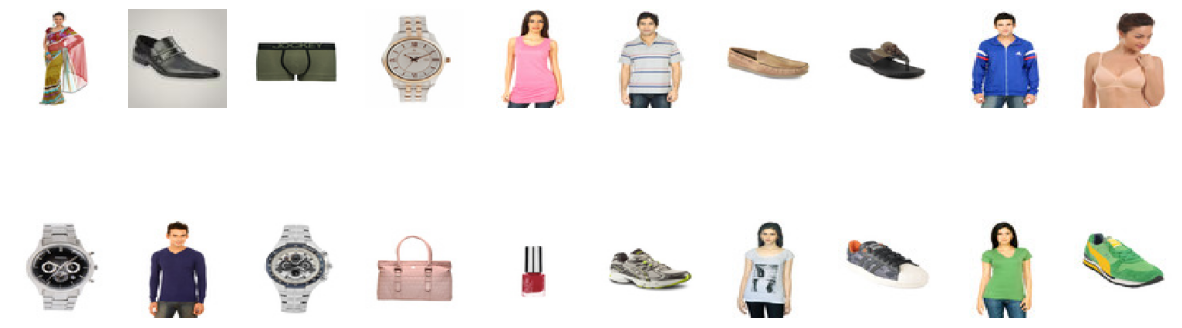

In [4]:
# Loading 20 random images from the data to explore the data


# Function to load random images with error checking
def load_random_images_with_error_check(image_paths, num_images, target_size=(128, 128)):
    random_sample = random.sample(list(image_paths), num_images)
    images = []
    for path in random_sample:
        image_path = os.path.join(image_dir, str(path) + '.jpg')
        if os.path.exists(image_path):
            try:
                img = load_img(image_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
        else:
            print(f"Image not found: {image_path}")
    return images

# Load 20 random images with error checking
random_sample_images = load_random_images_with_error_check(styles_df['id'], num_images=20)

# Display the random sample of images with a larger figure size
plt.figure(figsize=(15, 5))
for i in range(len(random_sample_images)):
    plt.subplot(2, 10, i + 1)  
    plt.imshow(random_sample_images[i] / 255.0)  # Normalize pixel values to [0, 1]
    plt.axis('off')
plt.show()


In [5]:
# Exploratory Data Analysis



# Checking null values in each column
styles_df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [6]:
# Exploring unique values of usage column

styles_df['usage'].unique()

array(['Casual', 'Ethnic', 'Formal', 'Sports', nan, 'Smart Casual',
       'Travel', 'Party', 'Home'], dtype=object)

In [7]:
# Identifying patterns for productDisplayName for null usage value 

styles_df[styles_df['usage'].isna()]

id  gender masterCategory       subCategory            articleType  \
87     56489   Women  Personal Care             Nails            Nail Polish   
92     52029  Unisex        Apparel           Topwear            Rain Jacket   
292    55001   Women  Personal Care              Lips               Lipstick   
479    57563   Women  Personal Care              Lips               Lipstick   
511    55006   Women  Personal Care              Lips              Lip Gloss   
...      ...     ...            ...               ...                    ...   
43650  56605   Women  Personal Care            Makeup     Kajal and Eyeliner   
44096  57715   Women  Personal Care              Lips              Lip Gloss   
44241  43120     Men  Personal Care         Fragrance  Perfume and Body Mist   
44244  55045   Women  Personal Care              Lips               Lipstick   
44360   6839  Unisex    Accessories  Shoe Accessories       Shoe Accessories   

         baseColour  season    year usage  \
87           Bronze  Spring  2017.0   NaN   
92     Coffee Brown  Summer  2012.0   NaN   
292            Pink  Spring  2017.0   NaN   
479           Brown  Spring  2017.0   NaN   
511          Copper  Spring  2017.0   NaN   
...             ...     ...     ...   ...   
43650         Black  Spring  2017.0   NaN   
44096           Red  Spring  2017.0   NaN   
44241           NaN  Spring  2017.0   NaN   
44244        Purple  Spring  2017.0   NaN   
44360         Black  Winter  2015.0   NaN   

                                      productDisplayName  
87                       Streetwear Ash Nail Polish # 31  
92              Just Natural Unisex Charcoal Rain Jacket  
292          Lakme Absolute Lip Last Day Kiss Lip Colour  
479    Lotus Herbals Pure Colours Nutty Brown Lipstic...  
511                       Lakme Sheer Satin Lip Gloss 51  
...                                                  ...  
43650                      Streetwear Black Eye Liner 01  
44096  Lotus Herbals Seduction Sappy Watermelon Lip G...  
44241        GUESS by Marciano Men Eau De Toilette 50 ml  
44244                   Lakme Enrich Satins Lipstick 461  
44360         Timberland Unisex Waximum Shoe Accessories  

[317 rows x 10 columns]

In [8]:
# Replacing all missing values in the 'usage' column with 'Cosmetic', as observed

styles_df['usage'].fillna('Cosmetic', inplace=True)
styles_df.isnull().sum()

id                     0
gender                 0
masterCategory         0
subCategory            0
articleType            0
baseColour            15
season                21
year                   1
usage                  0
productDisplayName     7
dtype: int64

In [9]:
#Choosing the Target Vector


#Investigating the potential of selecting the target vector as the productDisplayName, considering its blend of gender, articleType, and baseColor.

# Exploring unique values of gender column 
unique_genders = styles_df['gender'].unique()
unique_genders

array(['Men', 'Women', 'Boys', 'Girls', 'Unisex'], dtype=object)

In [10]:
# Determine the count of rows where the "gender" values are absent from the "productDisplayName" column.

unique_gender_strings = [str(gender) for gender in unique_genders]

# Convert the array to a regular expression pattern
pattern = '|'.join(re.escape(gender) for gender in unique_gender_strings)

# Filter out rows with NaN values in 'productDisplayName' column
valid_rows = pd.notna(styles_df['productDisplayName'])

# Find rows where product display name does not contain any of the unique gender
rows_without_gender = styles_df[valid_rows & ~styles_df['productDisplayName'].astype(str).str.contains(pattern, case=False)]

# Display the rows
rows_without_gender

id  gender masterCategory subCategory            articleType  \
18     51832   Women        Apparel   Innerwear                    Bra   
28     56019   Women  Personal Care        Lips               Lipstick   
31      4729    Boys        Apparel     Topwear                Tshirts   
57      4943     Men        Apparel     Topwear                 Shirts   
60     59607   Women        Apparel       Saree                 Sarees   
...      ...     ...            ...         ...                    ...   
44388  59218  Unisex    Accessories     Watches                Watches   
44395  54163   Women    Accessories   Jewellery    Necklace and Chains   
44407  45223     Men    Accessories     Watches                Watches   
44412   4938     Men        Apparel     Topwear                Tshirts   
44433  55283   Women  Personal Care      Makeup  Highlighter and Blush   

      baseColour  season    year   usage  \
18         Beige  Summer  2016.0  Casual   
28         Brown  Spring  2017.0  Casual   
31         Green  Summer  2011.0  Casual   
57         White  Summer  2011.0  Casual   
60          Grey    Fall  2012.0  Ethnic   
...          ...     ...     ...     ...   
44388      Black  Winter  2016.0  Casual   
44395     Silver    Fall  2012.0  Casual   
44407      White  Winter  2016.0  Casual   
44412       Grey  Summer  2011.0  Casual   
44433       Pink  Spring  2017.0  Casual   

                                      productDisplayName  
18                  Bwitch Beige Full-Coverage Bra BW335  
28     Colorbar Soft Touch Show Stopper Copper Lipsti...  
31     Disney Kids Boy's Crew Sea Life Sialing Green ...  
57        Gini and Jony Boy's Kaleb White Brown Kidswear  
60               FNF Pink & Grey Wedding Collection Sari  
...                                                  ...  
44388                      Titan Him & Her Black Watches  
44395                            Femella Silver Necklace  
44407  Casio Vintage Collection Analog-Digital Watch ...  
44412  Gini and Jony Boy's Kaden Grey Blue Infant Kid...  
44433  Lakme Absolute Cheek Chromatic Day Blushes Blu...  

[4086 rows x 10 columns]

In [11]:
# Exploring unique values of baseColour column 

unique_colour = styles_df['baseColour'].unique()
print(unique_colour)

['Navy Blue' 'Blue' 'Silver' 'Black' 'Grey' 'Green' 'Purple' 'White'
 'Beige' 'Brown' 'Bronze' 'Teal' 'Copper' 'Pink' 'Off White' 'Maroon'
 'Red' 'Khaki' 'Orange' 'Coffee Brown' 'Yellow' 'Charcoal' 'Gold' 'Steel'
 'Tan' 'Multi' 'Magenta' 'Lavender' 'Sea Green' 'Cream' 'Peach' 'Olive'
 'Skin' 'Burgundy' 'Grey Melange' 'Rust' 'Rose' 'Lime Green' 'Mauve'
 'Turquoise Blue' 'Metallic' 'Mustard' 'Taupe' 'Nude' 'Mushroom Brown' nan
 'Fluorescent Green']


In [12]:
# Determine the count of rows where the "baseColour" values are absent from the "productDisplayName" column

# Convert the array to strings
unique_colour_strings = [str(color) for color in unique_colour]

# Convert the array to a regular expression pattern
pattern = '|'.join(re.escape(color) for color in unique_colour_strings)

# Find rows where product display name does not contain any of the unique colors
rows_without_colors = styles_df[~styles_df['productDisplayName'].astype(str).str.contains(pattern, case=False)]

# Determine the count of rows
rows_without_colors

id  gender masterCategory       subCategory             articleType  \
5       1855     Men        Apparel           Topwear                 Tshirts   
8      29114     Men    Accessories             Socks                   Socks   
22      6842  Unisex    Accessories  Shoe Accessories        Shoe Accessories   
24     18461     Men  Personal Care         Fragrance               Deodorant   
66     43993   Women  Personal Care         Fragrance   Perfume and Body Mist   
...      ...     ...            ...               ...                     ...   
44413  56634   Women  Personal Care         Skin Care  Face Wash and Cleanser   
44424  32143     Men        Apparel         Innerwear                  Briefs   
44433  55283   Women  Personal Care            Makeup   Highlighter and Blush   
44436  17036     Men       Footwear             Shoes            Casual Shoes   
44437   6461     Men       Footwear        Flip Flops              Flip Flops   

      baseColour  season    year   usage  \
5           Grey  Summer  2011.0  Casual   
8      Navy Blue  Summer  2012.0  Casual   
22         Black  Summer  2011.0  Casual   
24         White  Spring  2017.0  Casual   
66          Pink  Spring  2017.0  Casual   
...          ...     ...     ...     ...   
44413      Black  Spring  2017.0  Casual   
44424        Red  Summer  2016.0  Casual   
44433       Pink  Spring  2017.0  Casual   
44436      White  Summer  2013.0  Casual   
44437        Red  Summer  2011.0  Casual   

                                      productDisplayName  
5                   Inkfruit Mens Chain Reaction T-shirt  
8                               Puma Men Pack of 3 Socks  
22     Timberland Unisex Rubber Sole Brush Shoe Acces...  
24                      David Beckham Signature Men Deos  
66                          Police Women Passion Perfume  
...                                                  ...  
44413   Olay Women Total Effects 7 in 1 Foaming Cleanser  
44424                  Playboy Men Duet Pack of 2 Briefs  
44433  Lakme Absolute Cheek Chromatic Day Blushes Blu...  
44436                          Gas Men Caddy Casual Shoe  
44437                 Lotto Men's Soccer Track Flip Flop  

[3401 rows x 10 columns]

In [13]:
# Exploring unique values of baseColour column

unique_article = styles_df['articleType'].unique()
print(unique_article)


['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sarees'
 'Perfume and Body Mist' 'Heels' 'Sunglasses' 'Innerwear Vests' 'Pendant'
 'Nail Polish' 'Laptop Bag' 'Scarves' 'Rain Jacket' 'Dresses'
 'Night suits' 'Skirts' 'Wallets' 'Blazers' 'Ring' 'Kurta Sets' 'Clutches'
 'Shrug' 'Backpacks' 'Caps' 'Trousers' 'Earrings' 'Camisoles' 'Boxers'
 'Jewellery Set' 'Dupatta' 'Capris' 'Lip Gloss' 'Bath Robe' 'Mufflers'
 'Tunics' 'Jackets' 'Trunk' 'Lounge Pants' 'Face Wash and Cleanser'
 'Necklace and Chains' 'Duffel Bag' 'Sports Sandals'
 'Foundation and Primer' 'Sweaters' 'Free Gifts' 'Trolley Bag'
 'Tracksuits' 'Swimwear' 'Shoe Laces' 'Fragrance Gift Set' 'Bangle'
 'Nightdress' 'Ties' 'Baby Dolls' 'Leggings' 'Highlighter and Blush'
 'Travel Accessory' 'Kurtis' 'Mobile Pou

In [14]:
# Determine the count of rows where the "articleType" values are absent from the "productDisplayName" column

# Convert the array to strings
unique_article_strings = [str(article) for article in unique_article]

# Convert the array to a regular expression pattern
pattern = '|'.join(re.escape(article) for article in unique_article_strings)

# Find rows where product display name does not contain any of the unique article
rows_without_article = styles_df[~styles_df['productDisplayName'].astype(str).str.contains(pattern, case=False)]

# Determine the count of rows
rows_without_article


id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
2      59263  Women    Accessories     Watches                Watches   
4      53759    Men        Apparel     Topwear                Tshirts   
5       1855    Men        Apparel     Topwear                Tshirts   
6      30805    Men        Apparel     Topwear                 Shirts   
...      ...    ...            ...         ...                    ...   
44436  17036    Men       Footwear       Shoes           Casual Shoes   
44437   6461    Men       Footwear  Flip Flops             Flip Flops   
44438  18842    Men        Apparel     Topwear                Tshirts   
44439  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44440  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
2         Silver  Winter  2016.0  Casual   
4           Grey  Summer  2012.0  Casual   
5           Grey  Summer  2011.0  Casual   
6          Green  Summer  2012.0  Ethnic   
...          ...     ...     ...     ...   
44436      White  Summer  2013.0  Casual   
44437        Red  Summer  2011.0  Casual   
44438       Blue    Fall  2011.0  Casual   
44439       Blue  Spring  2017.0  Casual   
44440       Pink  Winter  2016.0  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
2                             Titan Women Silver Watch  
4                                Puma Men Grey T-shirt  
5                 Inkfruit Mens Chain Reaction T-shirt  
6                     Fabindia Men Striped Green Shirt  
...                                                ...  
44436                        Gas Men Caddy Casual Shoe  
44437               Lotto Men's Soccer Track Flip Flop  
44438             Puma Men Graphic Stellar Blue Tshirt  
44439                   Rasasi Women Blue Lady Perfume  
44440  Fossil Women Pink Dial Chronograph Watch ES3050  

[27628 rows x 10 columns]

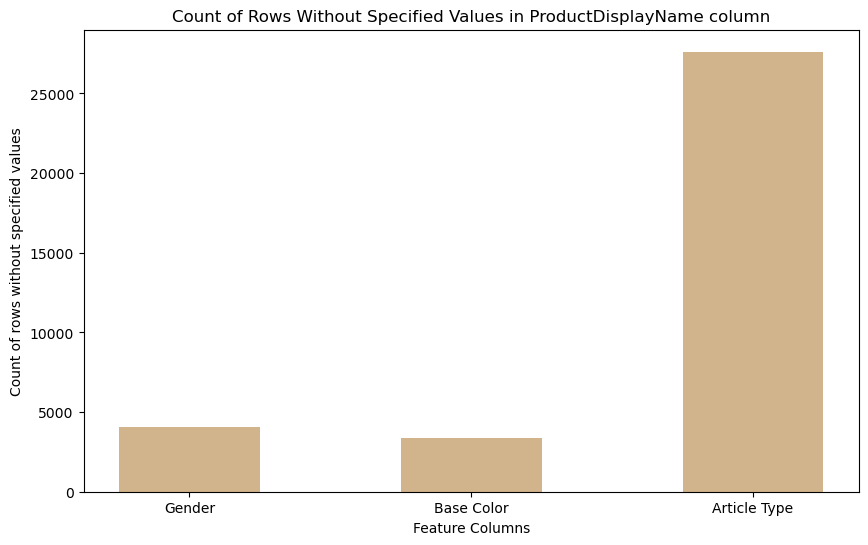

In [15]:
# Visualizing Counts of Rows Without Specified Values in Product Display Name Column


# Create a function to count rows without specified values in the "productDisplayName" column
def count_rows_without_values(column_values, column_name, df):
    # Convert the array to strings
    unique_strings = [str(value) for value in column_values]
    # Convert the array to a regular expression pattern
    pattern = '|'.join(re.escape(value) for value in unique_strings)
    # Filter out NaN values in 'productDisplayName' column
    valid_rows = pd.notna(df['productDisplayName'])
    # Find rows where product display name does not contain any of the unique values
    rows_without_values = df[valid_rows & ~df['productDisplayName'].astype(str).str.contains(pattern, case=False)]
    # Return the count of rows without specified values
    return len(rows_without_values)

# Count rows without gender values in productDisplayName
rows_without_gender = count_rows_without_values(unique_genders, 'gender', styles_df)

# Count rows without base color values in productDisplayName
rows_without_colors = count_rows_without_values(unique_colour, 'baseColor', styles_df)

# Count rows without article type values in productDisplayName
rows_without_article = count_rows_without_values(unique_article, 'articleType', styles_df)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(['Gender', 'Base Color', 'Article Type'], [rows_without_gender, rows_without_colors, rows_without_article], color='tan', width=0.5)
plt.xlabel('Feature Columns')
plt.ylabel('Count of rows without specified values')
plt.title('Count of Rows Without Specified Values in ProductDisplayName column')
plt.show()


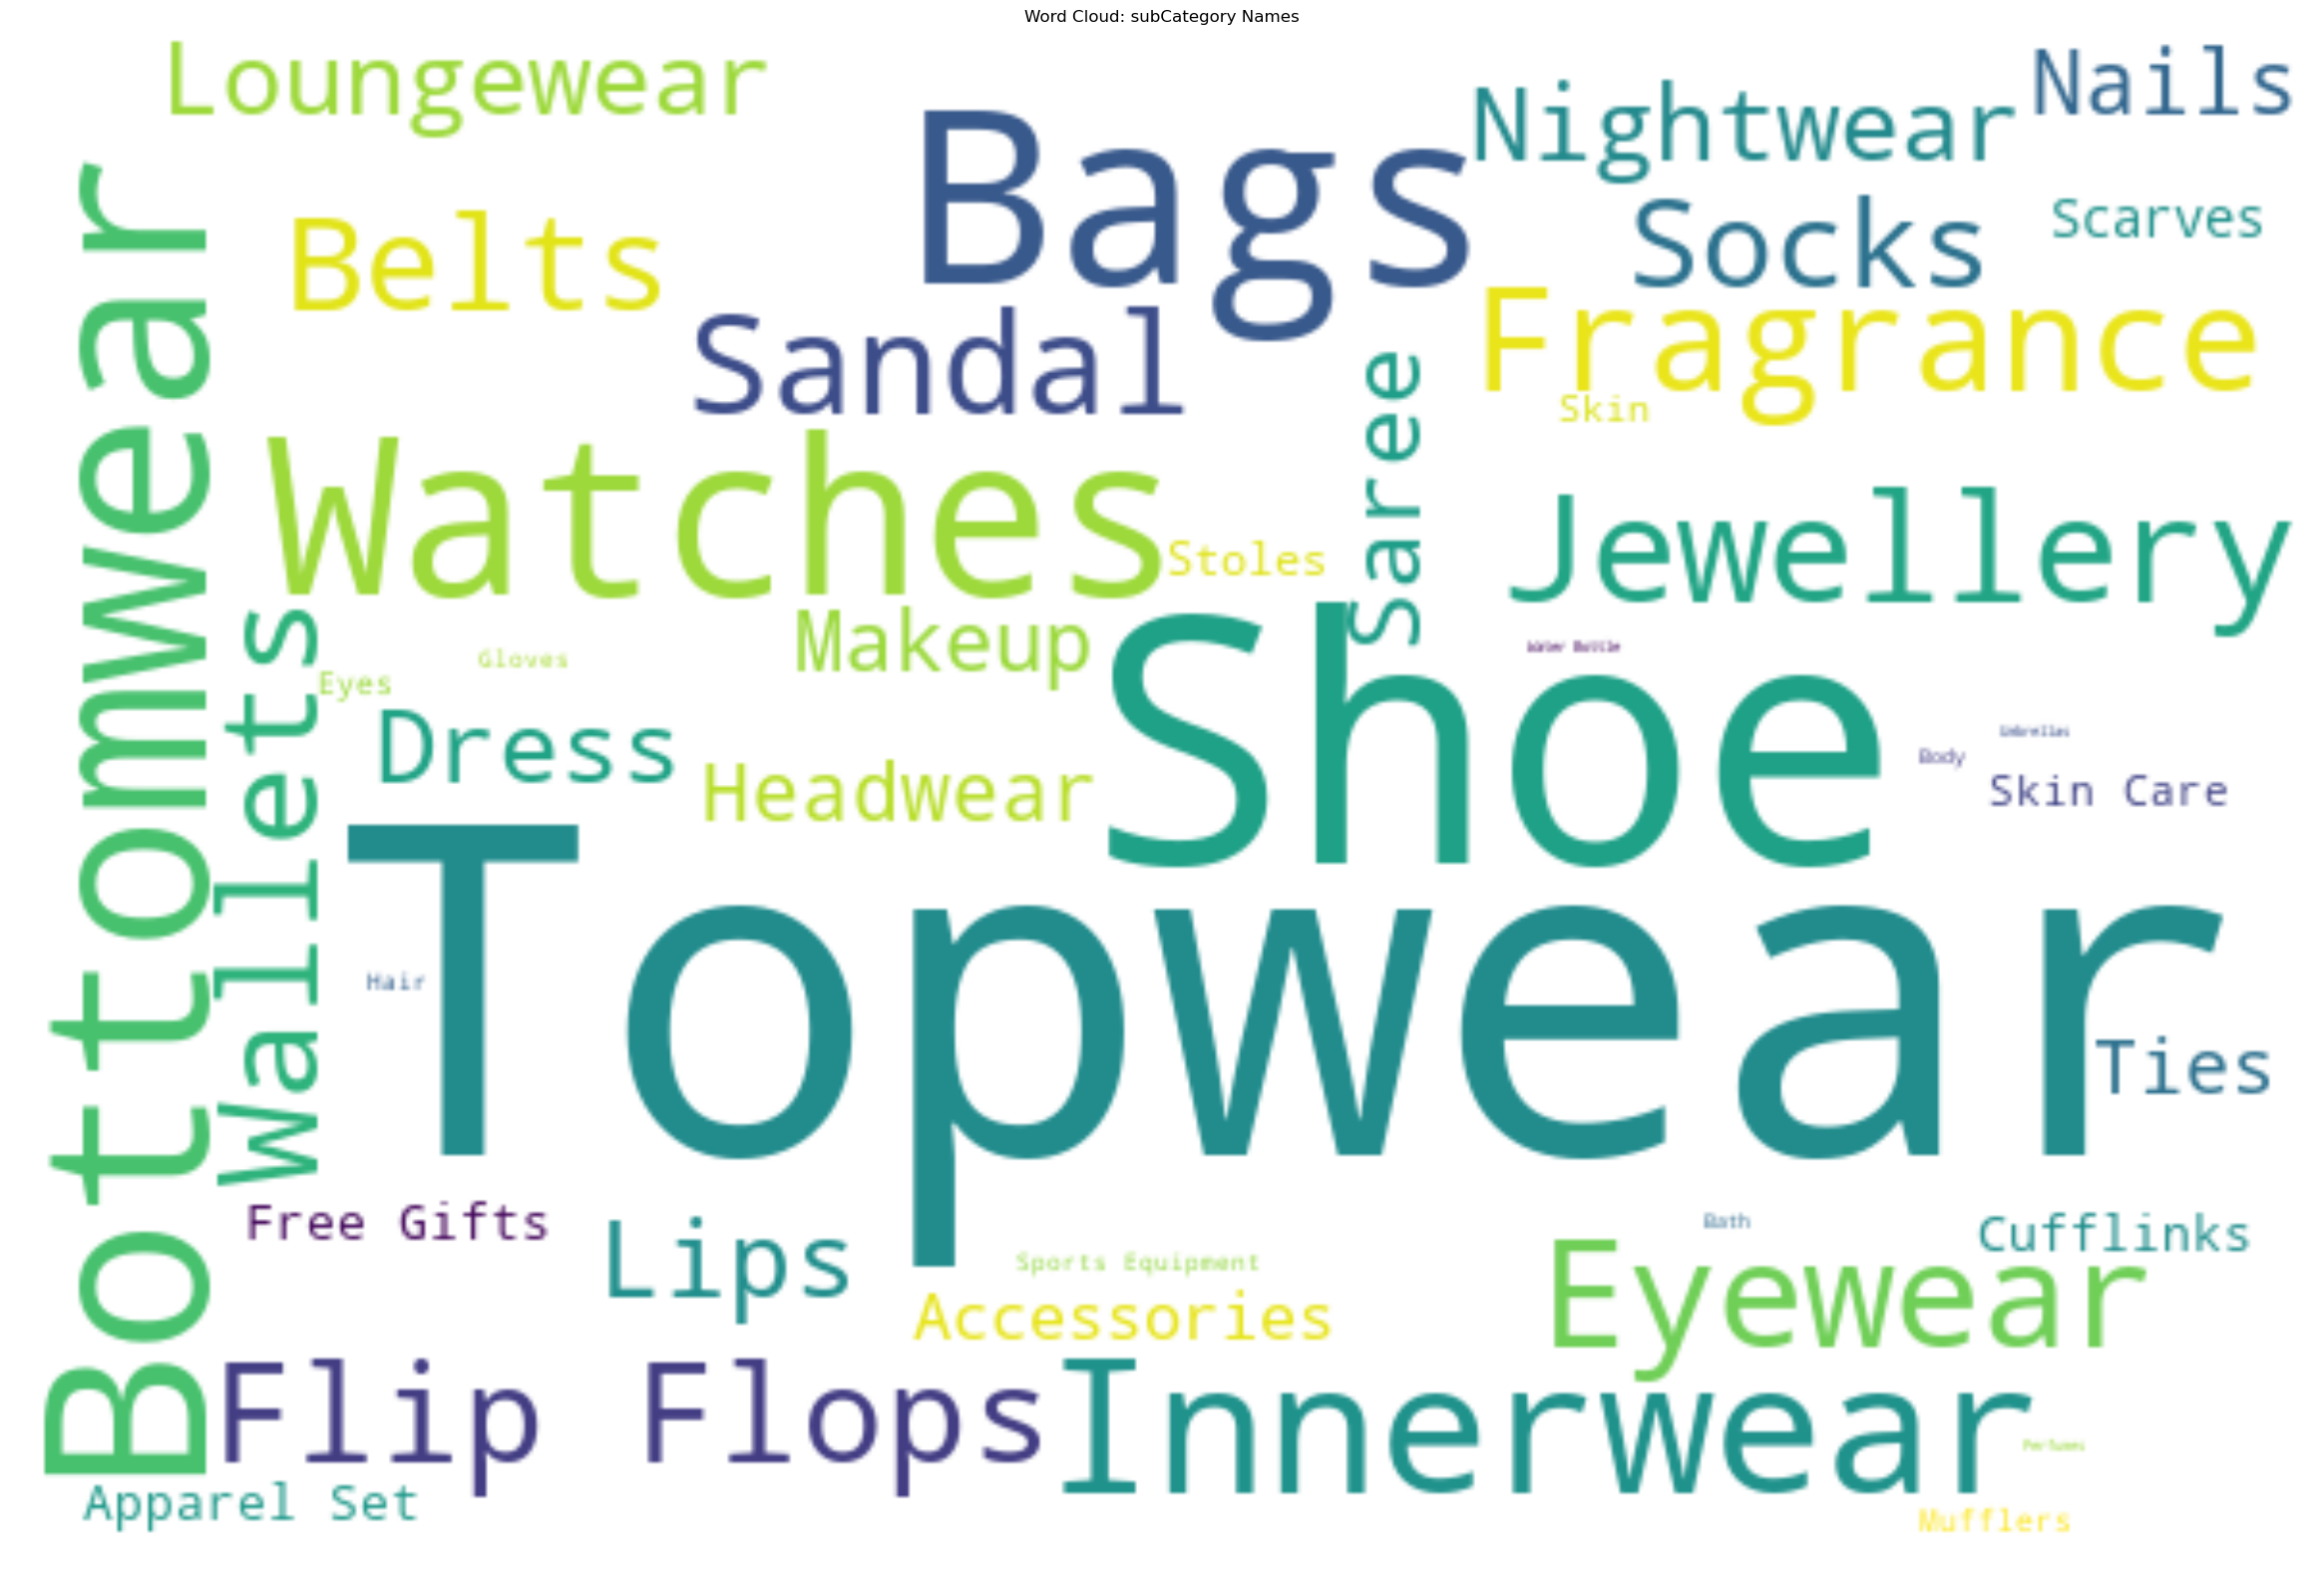

In [16]:
# Exploring subCategory Column for Target Vector


# Word cloud for frequently occurring words in subCategory 
wordcloud_data = ' '.join(styles_df['subCategory'].astype(str).tolist())
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(wordcloud_data)
plt.figure(figsize=(50, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: subCategory Names')
plt.show()

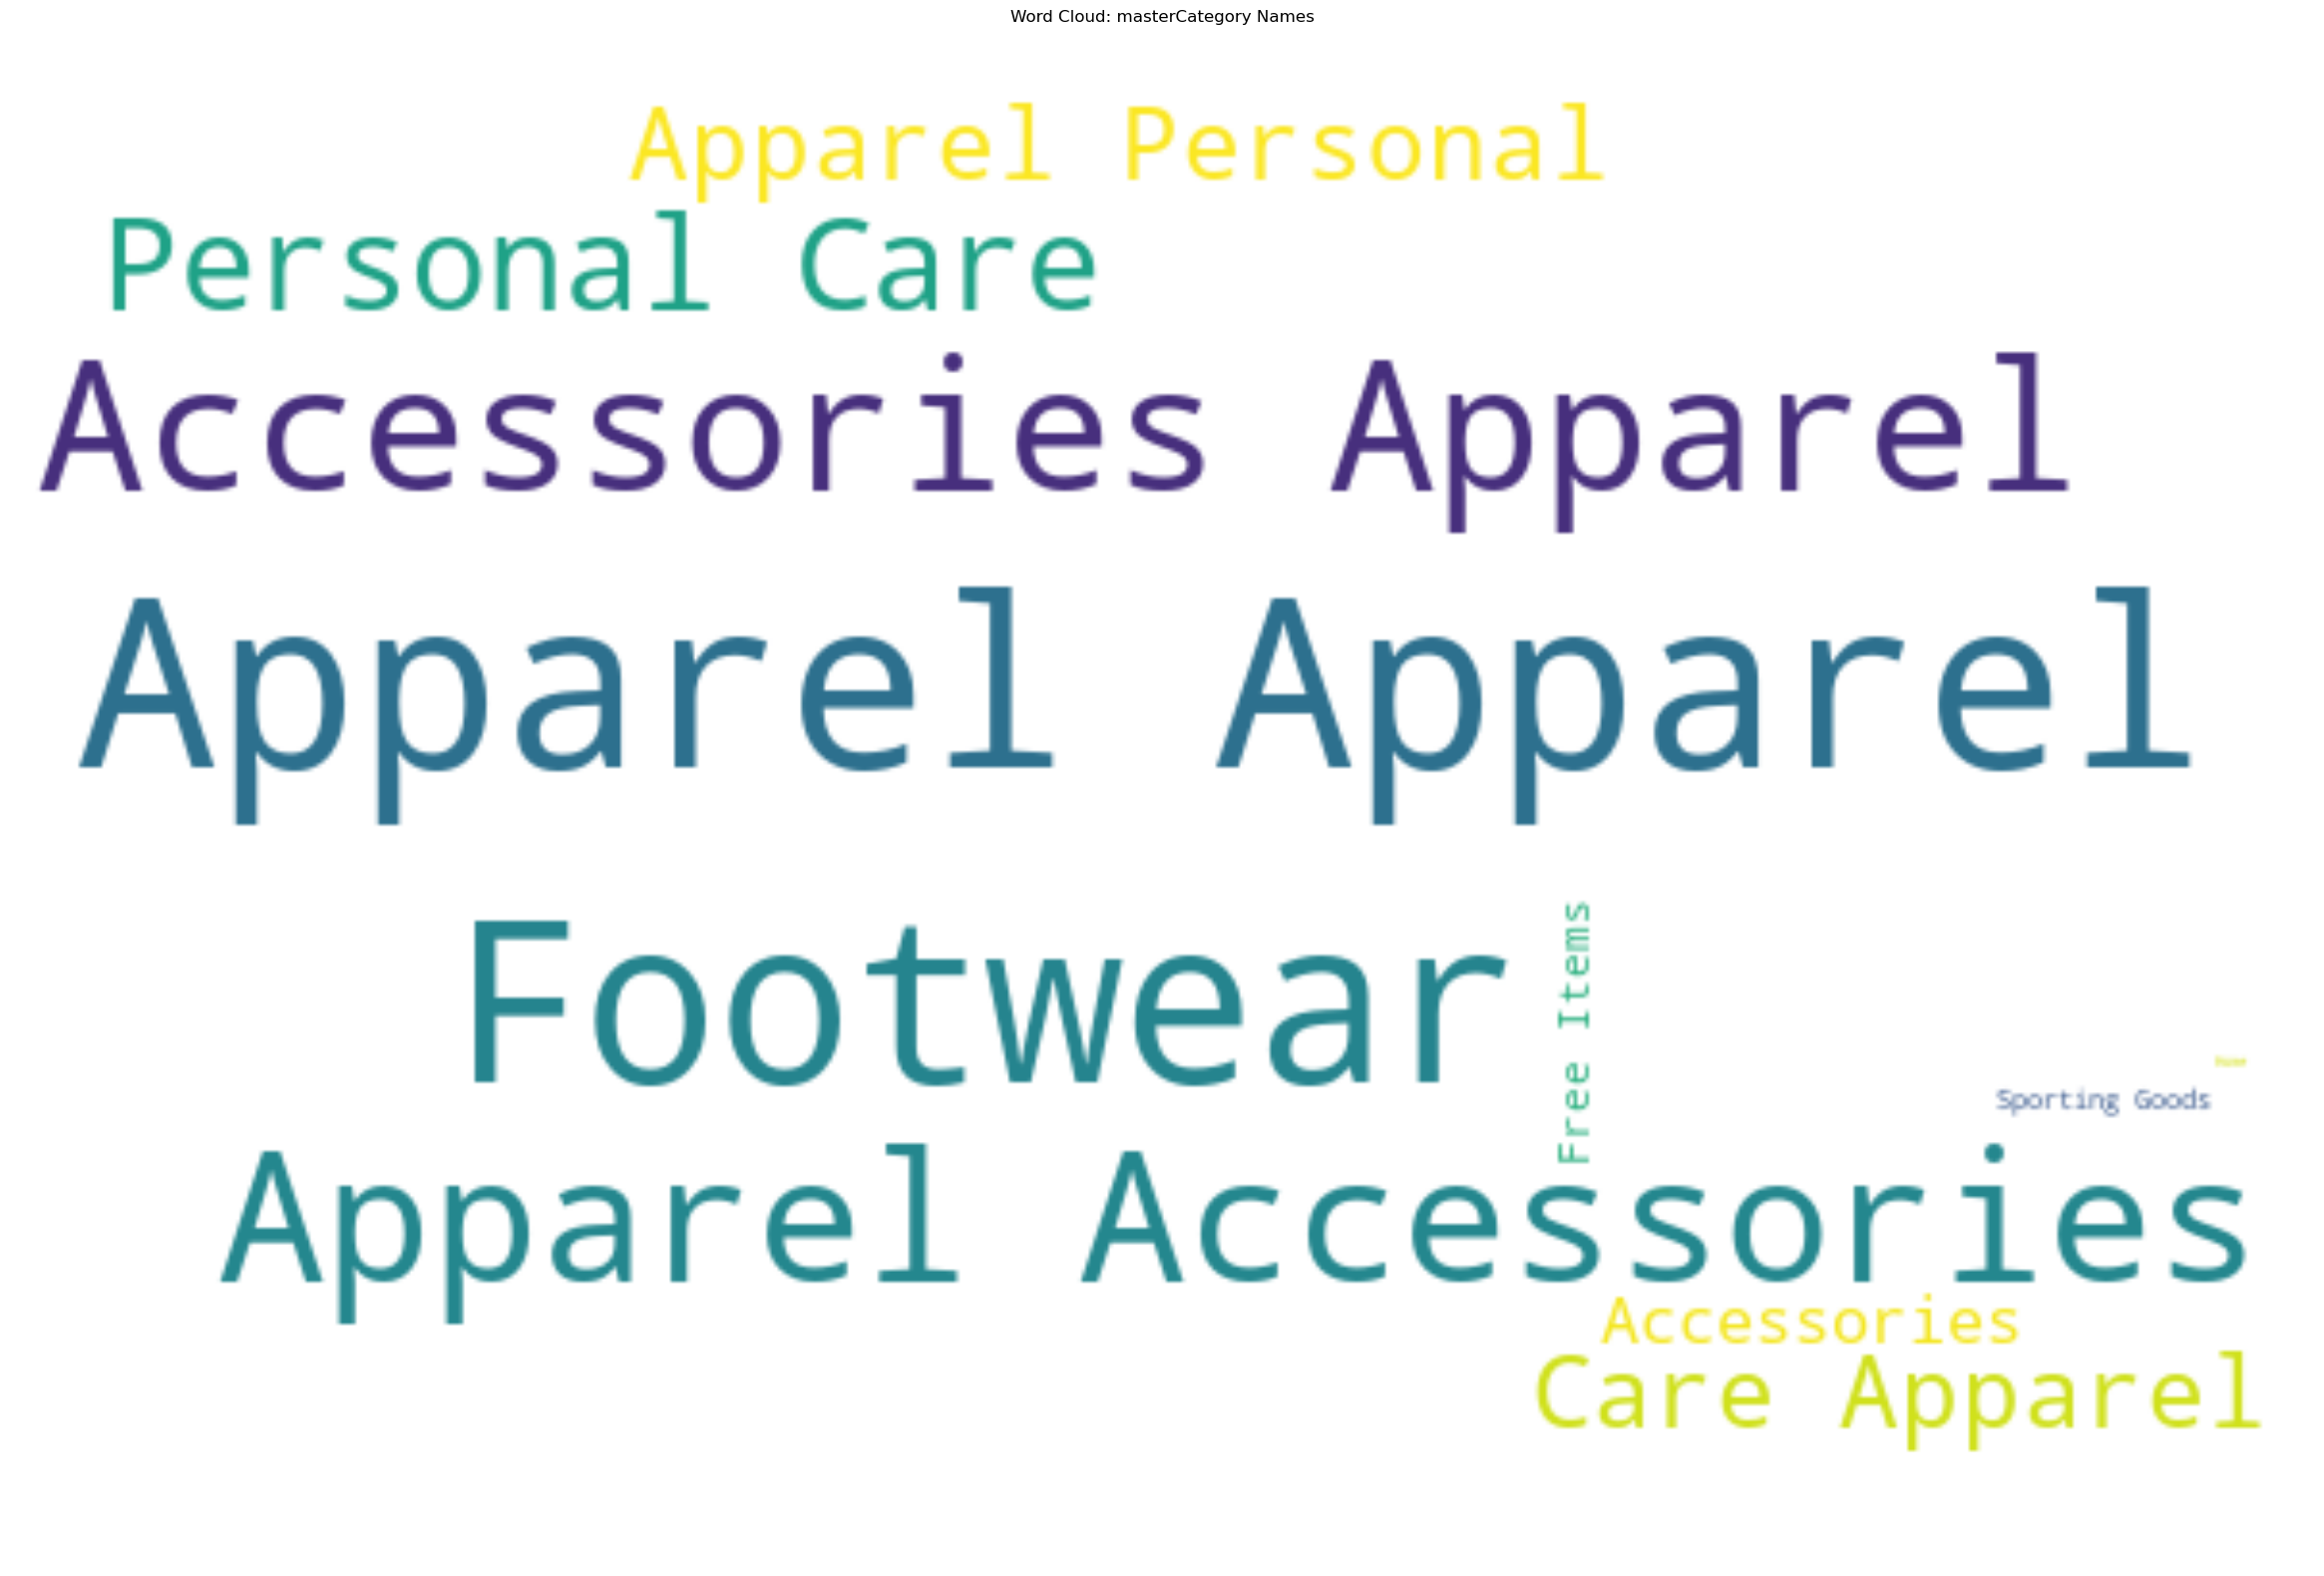

In [17]:
# Exploring masterCategory Column for Target Vector

# Word cloud for frequently occurring words in masterCategory 
wordcloud_data = ' '.join(styles_df['masterCategory'].astype(str).tolist())
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(wordcloud_data)
plt.figure(figsize=(50, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: masterCategory Names')
plt.show()

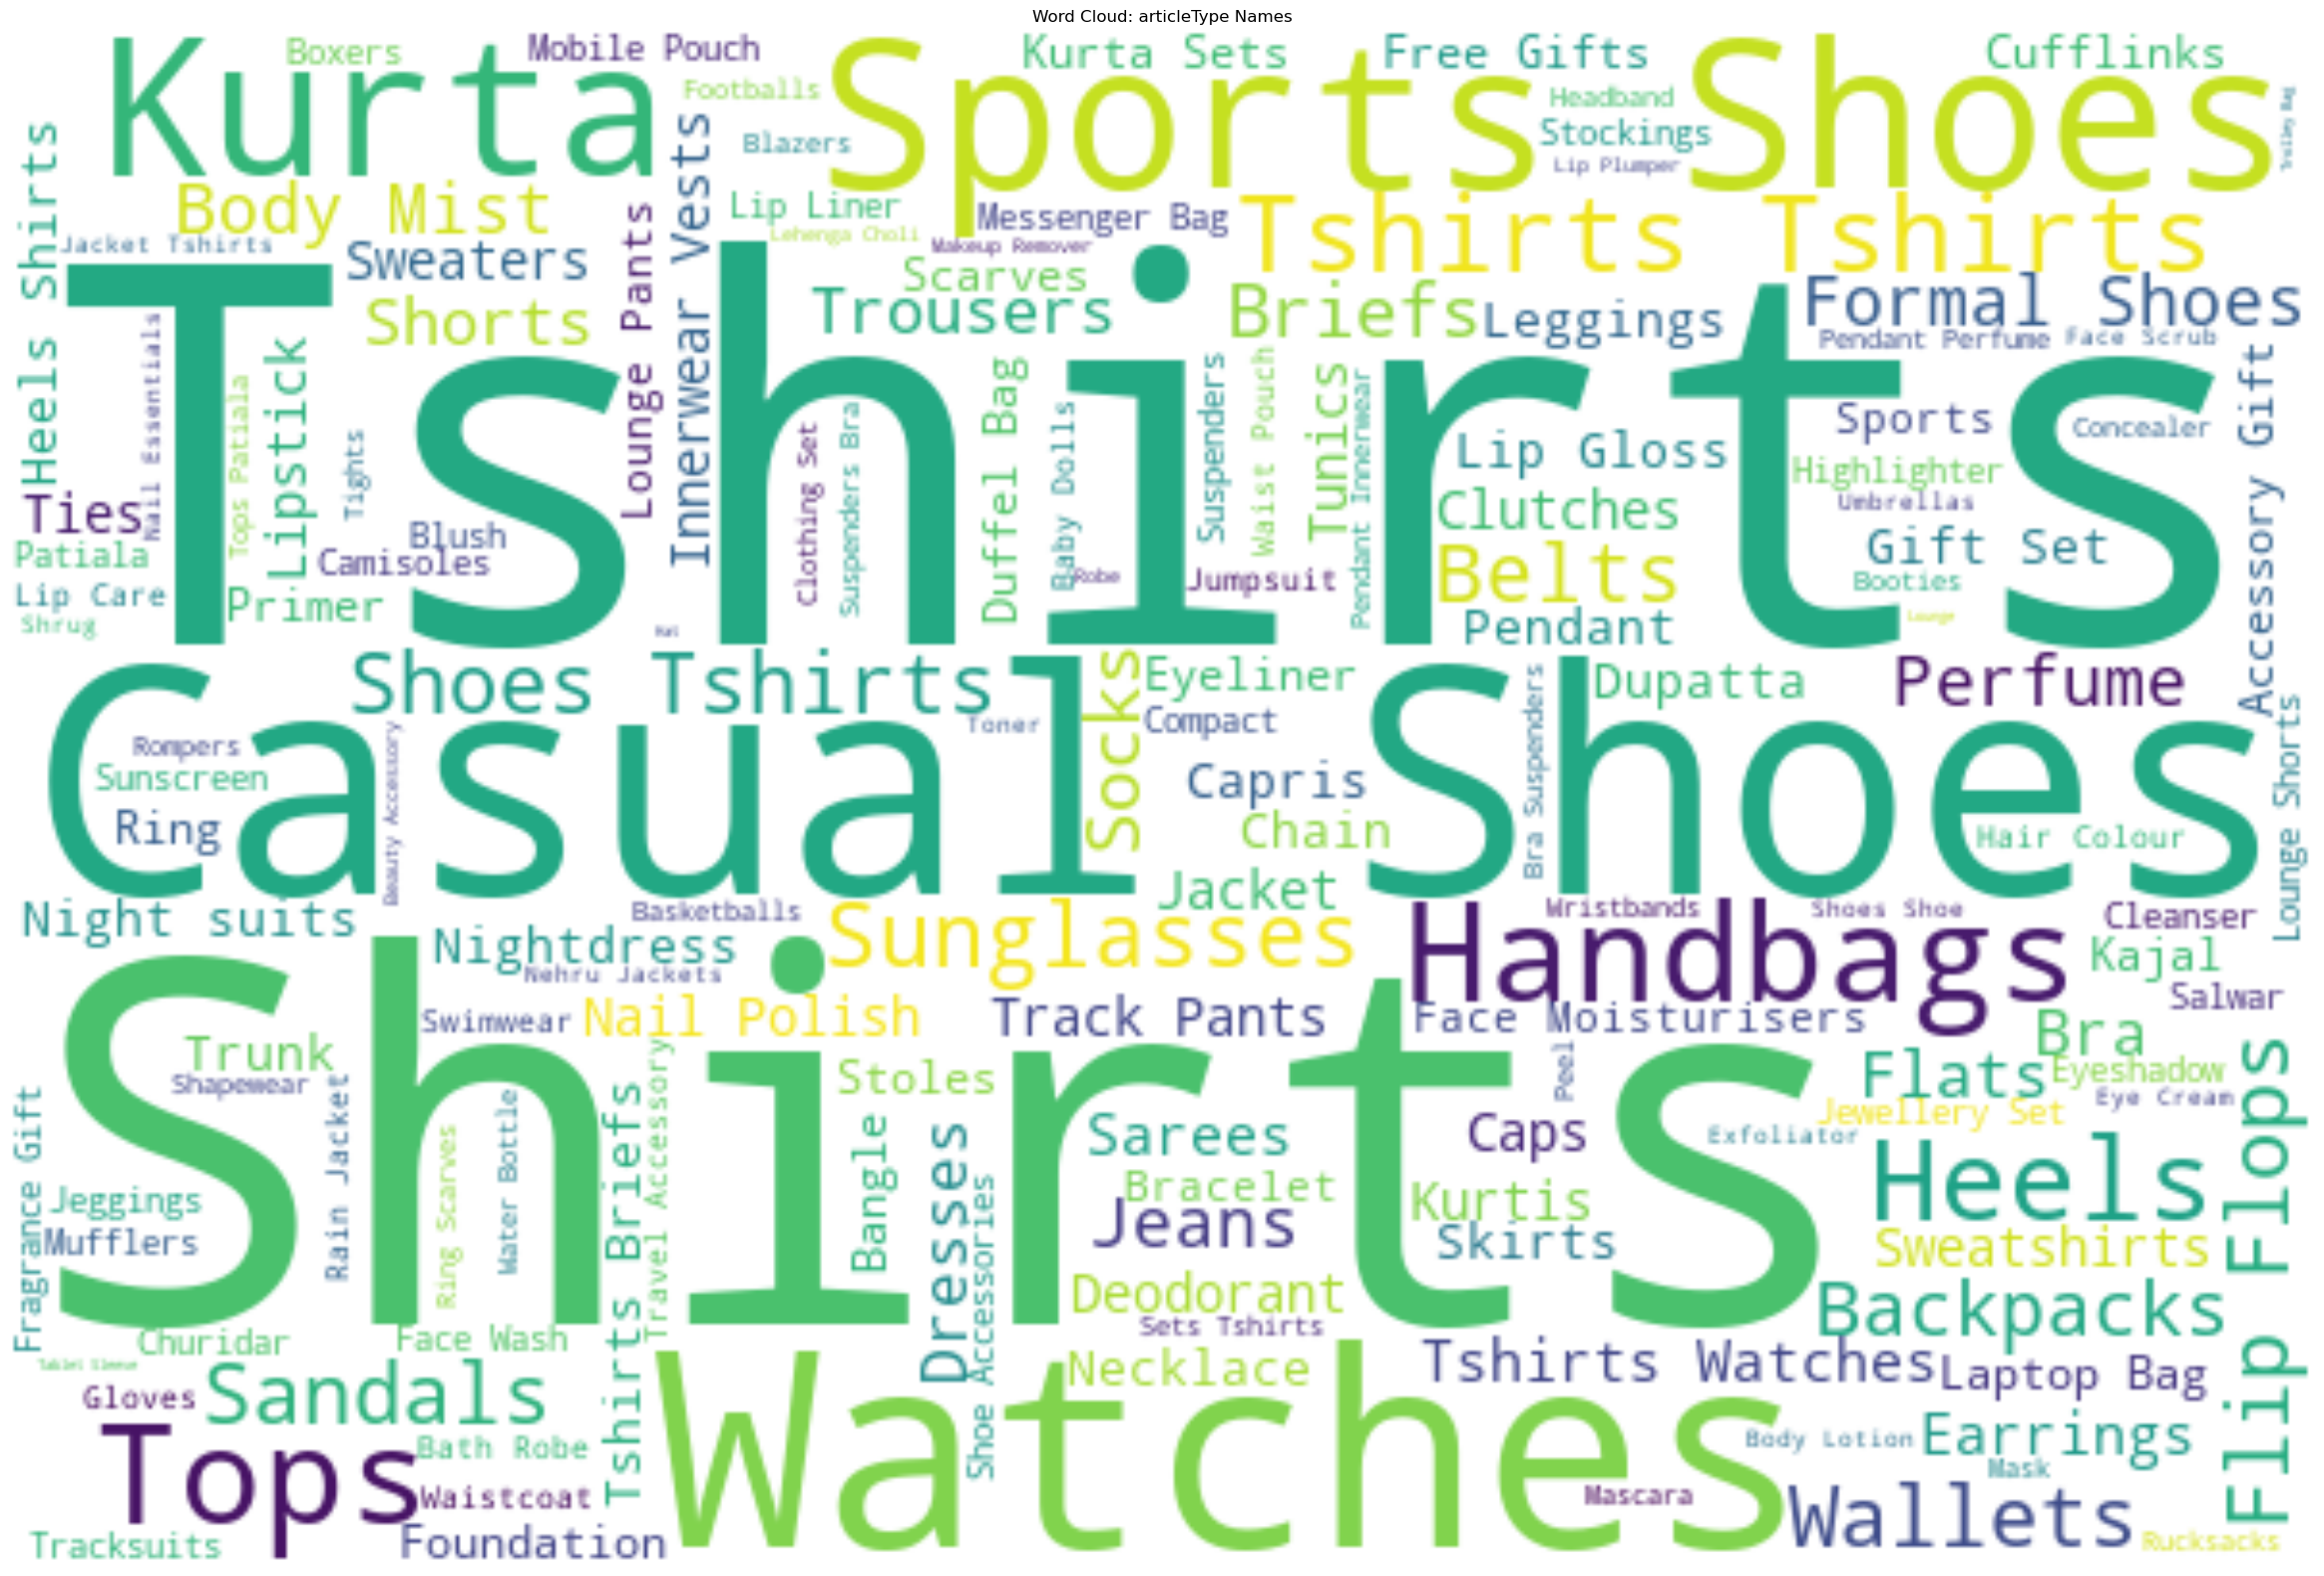

In [18]:
# Exploring articleType Column for Target Vector

# Word cloud for frequently occurring words in articleType 
wordcloud_data = ' '.join(styles_df['articleType'].astype(str).tolist())
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(wordcloud_data)
plt.figure(figsize=(50, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: articleType Names')
plt.show()

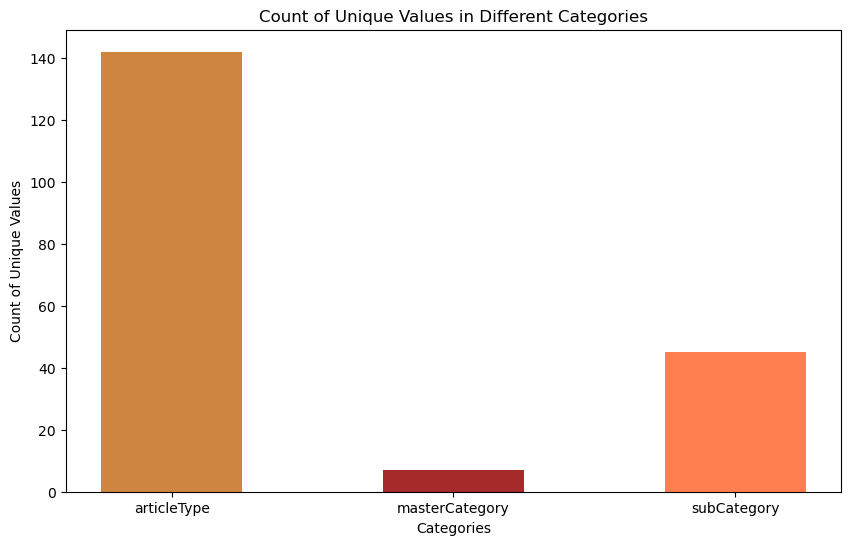

In [19]:
# Comparison of Unique Values Across Product Categories to select target vector: articleType vs masterCategory vs subCategory

# Count of unique values in each category
category_counts = [len(styles_df['articleType'].unique()), 
                   len(styles_df['masterCategory'].unique()), 
                   len(styles_df['subCategory'].unique())]

# Category labels
categories = ['articleType', 'masterCategory', 'subCategory']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, category_counts, color=['peru', 'brown', 'coral'],width=0.5)
plt.xlabel('Categories')
plt.ylabel('Count of Unique Values')
plt.title('Count of Unique Values in Different Categories')
plt.show()


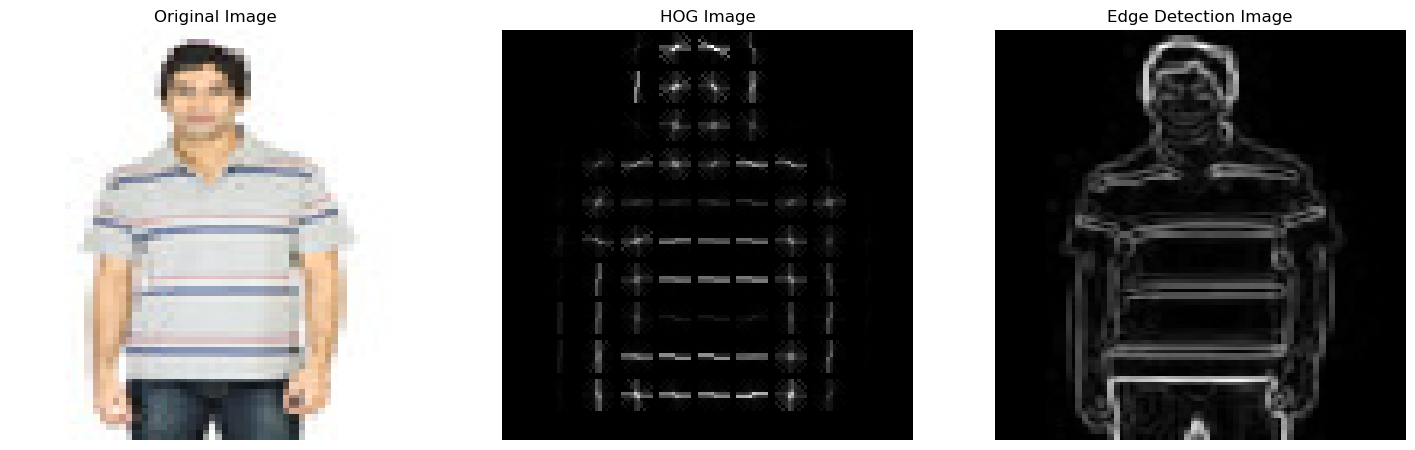

In [20]:
# Extracting histogram of gradients and Edge Detection features from a random image

def plot_image_features(image):
    # Ensure the image is in grayscale
    gray_image = color.rgb2gray(image)
    
    # Extract HOG features
    fd, hog_image = hog(gray_image, orientations=10, pixels_per_cell=(12, 12),
                        cells_per_block=(1, 1), visualize=True)
    
    # Perform edge detection using the Sobel operator
    edges = sobel(gray_image)
    
    # Create a figure to display the results
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show original image
    ax[0].imshow(image/255)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Show HOG image
    ax[1].imshow(hog_image, cmap='gray')
    ax[1].set_title('HOG Image')
    ax[1].axis('off')
    
    # Show edge detection image
    ax[2].imshow(edges, cmap='gray')
    ax[2].set_title('Edge Detection Image')
    ax[2].axis('off')
    
    plt.show()

plot_image_features(random_sample_images[5])


In [26]:
# Feature Extraction using VGG16 Model: Restructuring to ony extract image Features

# load the model
model = VGG16()

# restructure the model to just extract the features by removing the prediction layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summary
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:


def load_sample_images(image_paths, image_dir, model):
    features = {}
    for image_id in tqdm(image_paths, desc='Loading Images'):
        image_path = os.path.join(image_dir, str(image_id) + '.jpg')
        try:
            img = load_img(image_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = img_array.reshape((1, *img_array.shape))
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array, verbose=0)
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing image {image_id}: {e}")
    return features

# Example usage:
features = load_sample_images(styles_df['id'].tolist(), image_dir, model)


Loading Images:   0%|          | 102/44441 [00:16<2:00:15,  6.14it/s]

KeyboardInterrupt



In [ ]:

features

In [ ]:
styles_df['image_features'] = None

# Define a function to convert the array into a string representation with a delimiter
def array_to_string(arr):
    return ','.join(map(str, arr))

# Iterate over each row in the DataFrame
for index, row in styles_df.iterrows():
    # Get the ID of the image for the current row
    image_id = row['id']
    
    # Check if the image ID exists in the features dictionary
    if image_id in features:
        # If the image ID exists, convert the array to a string with a delimiter and assign it to the 'image_features' column
        styles_df.at[index, 'image_features'] = array_to_string(features[image_id][0])


In [ ]:
# Display the updated DataFrame
styles_df

In [ ]:
styles_df.to_csv('df_feature.csv', index=False)

In [21]:
# Reading from csv file with image_features column

def string_to_array(s):
    return np.array(list(map(float, s.split(','))))

# Read the CSV file into a DataFrame
df = pd.read_csv('df_feature.csv')

In [22]:
df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44436  17036    Men       Footwear       Shoes           Casual Shoes   
44437   6461    Men       Footwear  Flip Flops             Flip Flops   
44438  18842    Men        Apparel     Topwear                Tshirts   
44439  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44440  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44436      White  Summer  2013.0  Casual   
44437        Red  Summer  2011.0  Casual   
44438       Blue    Fall  2011.0  Casual   
44439       Blue  Spring  2017.0  Casual   
44440       Pink  Winter  2016.0  Casual   

                                    productDisplayName  \
0                     Turtle Check Men Navy Blue Shirt   
1                   Peter England Men Party Blue Jeans   
2                             Titan Women Silver Watch   
3        Manchester United Men Solid Black Track Pants   
4                                Puma Men Grey T-shirt   
...                                                ...   
44436                        Gas Men Caddy Casual Shoe   
44437               Lotto Men's Soccer Track Flip Flop   
44438             Puma Men Graphic Stellar Blue Tshirt   
44439                   Rasasi Women Blue Lady Perfume   
44440  Fossil Women Pink Dial Chronograph Watch ES3050   

                                          image_features  
0      0.0,1.2444998,2.4860902,0.0,0.0,0.0,0.0,0.0,0....  
1      1.1731346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...  
2      3.898272,4.809345,0.22958708,0.0,0.0,1.3078917...  
3      0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0201...  
4      0.89182836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00802...  
...                                                  ...  
44436  0.0,0.0,1.9859048,0.35997108,0.0,0.94505244,0....  
44437  0.0,0.0,1.0925802,0.0,0.0,0.0,0.0,1.4292269,1....  
44438  0.0,0.0,0.0,0.0,0.0,0.0023473501,0.0,2.7388725...  
44439  0.0,0.0,0.0,0.15067218,0.0,0.0,0.0,0.6112774,0...  
44440  3.089394,3.4503493,0.0,0.0,0.0,0.996674,0.0,0....  

[44441 rows x 11 columns]

In [23]:
#checking for class imbalance
article_count=df['articleType'].value_counts()
print(article_count)

articleType
Tshirts                7069
Shirts                 3215
Casual Shoes           2846
Watches                2542
Sports Shoes           2036
                       ... 
Shoe Laces                1
Cushion Covers            1
Mens Grooming Kit         1
Body Wash and Scrub       1
Ipad                      1
Name: count, Length: 142, dtype: int64


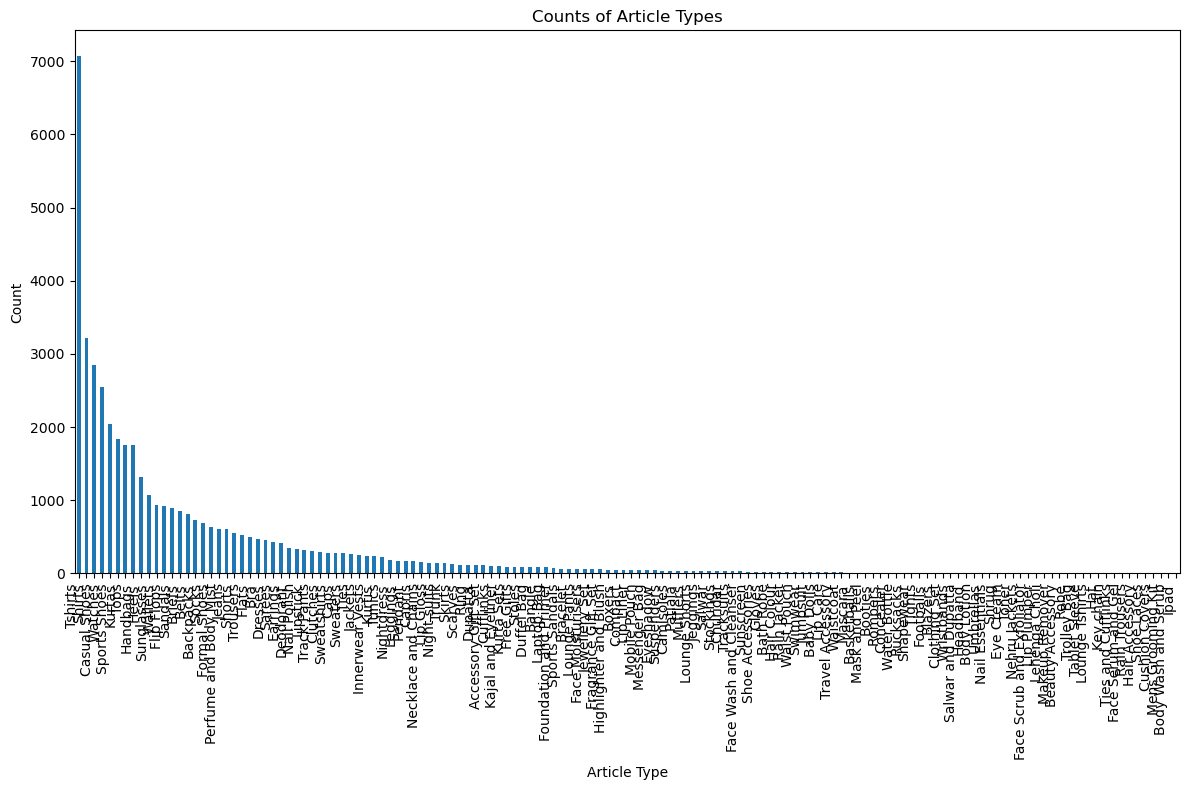

In [24]:
plt.figure(figsize=(12, 8))
article_count.plot(kind='bar')
plt.title('Counts of Article Types')
plt.xlabel('Article Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [25]:
#reducing Tshirt samples to balance the classes
tshirt_rows = df[df['articleType'] == 'Tshirts']

if tshirt_rows.shape[0] >= 2000:
    # Randomly select 2000 rows to delete
    rows_to_delete = tshirt_rows.sample(n=2000, random_state=42)
    df = df.drop(rows_to_delete.index)
else:
    print("Warning: There are fewer than 2000 rows with articleType 'Tshirts'.")

In [26]:
article_count=df['articleType'].value_counts()
print(article_count)

articleType
Tshirts                5069
Shirts                 3215
Casual Shoes           2846
Watches                2542
Sports Shoes           2036
                       ... 
Shoe Laces                1
Cushion Covers            1
Mens Grooming Kit         1
Body Wash and Scrub       1
Ipad                      1
Name: count, Length: 142, dtype: int64


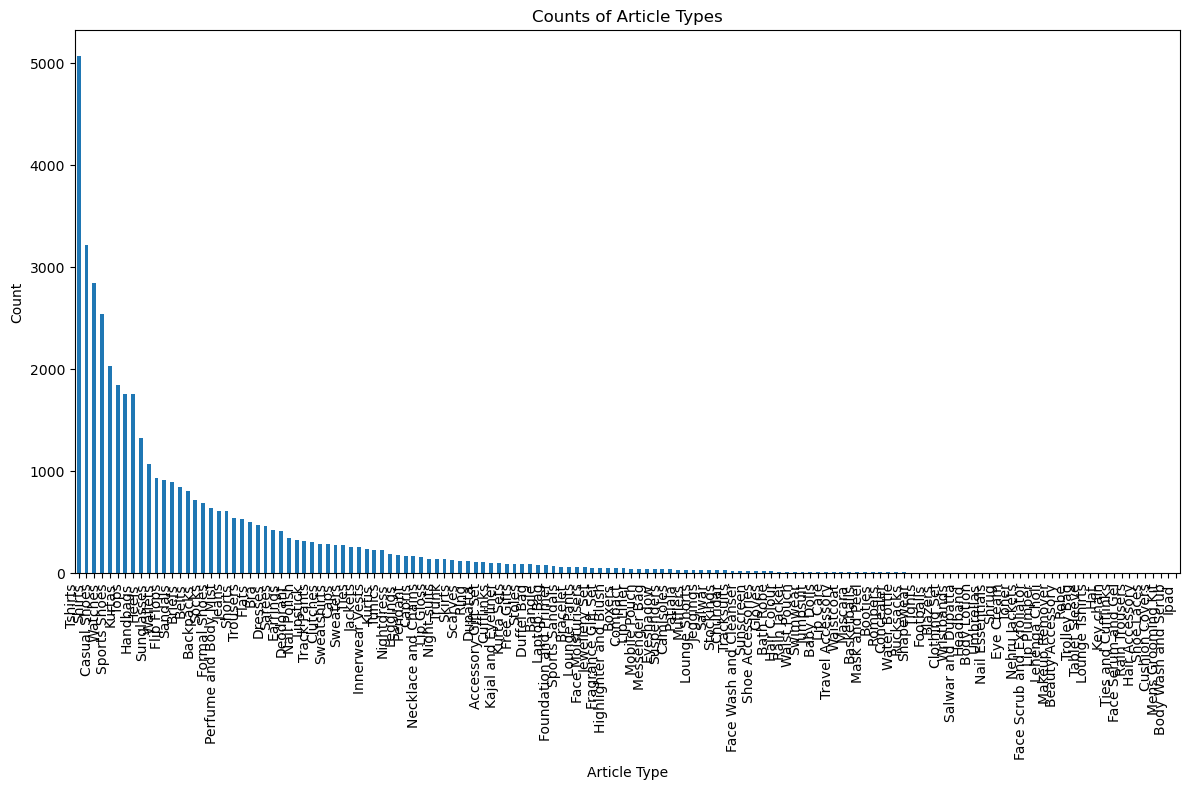

In [27]:
plt.figure(figsize=(12, 8))
article_count.plot(kind='bar')
plt.title('Counts of Article Types')
plt.xlabel('Article Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [28]:
#removing classes who have less than 25 samples(because we need more training data for those classes)
filtered_indices = df['articleType'].value_counts()[df['articleType'].value_counts() > 25].index
df= df[df['articleType'].isin(filtered_indices)]

In [29]:
filtered_indices.value_counts()

articleType
Tshirts                   1
Kajal and Eyeliner        1
Sports Sandals            1
Foundation and Primer     1
Laptop Bag                1
                         ..
Deodorant                 1
Earrings                  1
Sarees                    1
Dresses                   1
Face Wash and Cleanser    1
Name: count, Length: 86, dtype: int64

In [30]:
# Label Encoding for Categorical Data Transformation

le = LabelEncoder()

In [31]:
# Selecting Target Vector (y) and Feature Matrix (X)

#  converting feature string to array
X = df['image_features'].apply(lambda x: [float(val) for val in x.split(',')])

#converting to 2d array
X = np.array(X.tolist())

y=df['articleType']
y=le.fit_transform(y)

In [32]:
# Splitting Data into Training and Testing Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Dimensionality Reduction with PCA

pca = PCA(n_components=100, svd_solver='randomized')

In [34]:
# Fitting PCA to Feature Matrix

pca.fit(X)

PCA(n_components=100, svd_solver='randomized')

In [35]:
# Calculating Cumulative Variance Explained by Principal Components

cummulative_variance=np.cumsum(pca.explained_variance_ratio_)
cummulative_variance

array([0.1537675 , 0.20652471, 0.25047535, 0.28614819, 0.31552986,
       0.34197354, 0.36635991, 0.38934633, 0.41068221, 0.42917304,
       0.44708487, 0.46380014, 0.47879695, 0.49161917, 0.50407172,
       0.51595676, 0.52734569, 0.53728852, 0.54716302, 0.55607735,
       0.56452869, 0.57280955, 0.58102895, 0.58889974, 0.59606337,
       0.60301605, 0.60939602, 0.61555737, 0.62139259, 0.62710307,
       0.63268471, 0.63804226, 0.64326427, 0.64834219, 0.65316111,
       0.65784552, 0.66242429, 0.66685405, 0.67111805, 0.67515191,
       0.67903127, 0.68280157, 0.68655936, 0.69023034, 0.69372776,
       0.69716172, 0.70041935, 0.70359236, 0.70670451, 0.70968475,
       0.71258854, 0.71545473, 0.71829805, 0.72106341, 0.72378052,
       0.72644052, 0.72902648, 0.73155212, 0.73399269, 0.736314  ,
       0.73853824, 0.74075509, 0.74292572, 0.74504766, 0.74713436,
       0.74921428, 0.75126433, 0.75320173, 0.75512367, 0.75700951,
       0.75885635, 0.76066462, 0.76244108, 0.76420207, 0.76588

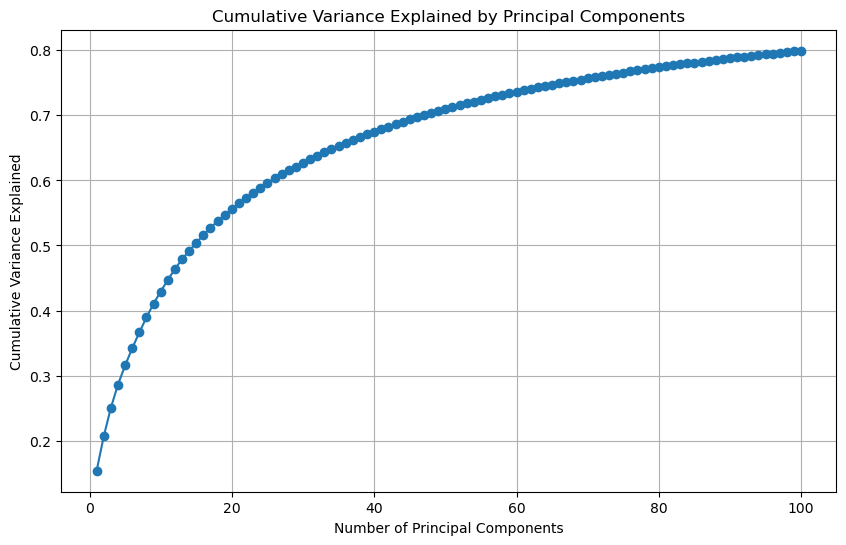

In [36]:
# Visualization of Cumulative Variance Explained by Principal Components


plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cummulative_variance) + 1), cummulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()


In [37]:
# Transforming Training and Testing Data with PCA

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [38]:
# Training and Evaluating Logistic Regression Model with PCA-Transformed Data

# Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=300)
logreg_model.fit(X_train_pca, y_train)

# Predict with the Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test_pca)

# Evaluate Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy (Logistic Regression):", accuracy_logreg)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))

Accuracy (Logistic Regression): 0.7952568227863187
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.89      0.90      0.89       141
           2       0.71      0.50      0.59        20
           3       0.98      0.96      0.97       184
           4       0.80      0.67      0.73        12
           5       0.94      0.98      0.96       115
           6       0.52      0.79      0.63        14
           7       0.95      0.94      0.95       174
           8       0.22      1.00      0.36         2
           9       0.34      0.31      0.32        36
          10       0.79      0.92      0.85        59
          11       0.76      0.76      0.76       527
          12       0.71      0.83      0.77         6
          13       0.65      0.56      0.60        62
          14       1.00      0.91      0.95        11
          15       0.78      0.82     

In [39]:
# Training and Evaluating KNN Model with PCA-Transformed Data

# Train KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_pca, y_train)

# Predict with the KNN model
y_pred_knn = knn_model.predict(X_test_pca)

# Evaluate KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy (KNN):", accuracy_knn)
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))


Accuracy (KNN): 0.7789298057442497
Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.88      0.94      0.91       141
           2       0.62      0.65      0.63        20
           3       0.99      0.98      0.99       184
           4       0.75      0.50      0.60        12
           5       0.96      0.98      0.97       115
           6       0.64      0.50      0.56        14
           7       0.94      0.95      0.95       174
           8       0.33      0.50      0.40         2
           9       0.29      0.42      0.34        36
          10       0.96      0.88      0.92        59
          11       0.67      0.74      0.70       527
          12       0.43      0.50      0.46         6
          13       0.53      0.45      0.49        62
          14       0.69      0.82      0.75        11
          15       0.64      0.82      0.72        17
          16    

In [40]:
# Training and Evaluating SVM Model with PCA-Transformed Data

# Train SVM model
svm_model = SVC()
svm_model.fit(X_train_pca, y_train)

# Predict with the SVM model
y_pred_svm = svm_model.predict(X_test_pca)

# Evaluate SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy (SVM):", accuracy_svm)
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))


Accuracy (SVM): 0.8250506495054225
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.94      0.93      0.94       141
           2       0.80      0.60      0.69        20
           3       1.00      0.98      0.99       184
           4       1.00      0.50      0.67        12
           5       0.97      0.98      0.97       115
           6       0.80      0.57      0.67        14
           7       0.98      0.98      0.98       174
           8       1.00      0.50      0.67         2
           9       0.50      0.44      0.47        36
          10       0.96      0.92      0.94        59
          11       0.75      0.81      0.78       527
          12       0.75      0.50      0.60         6
          13       0.67      0.53      0.59        62
          14       0.82      0.82      0.82        11
          15       0.93      0.76      0.84        17
          16    

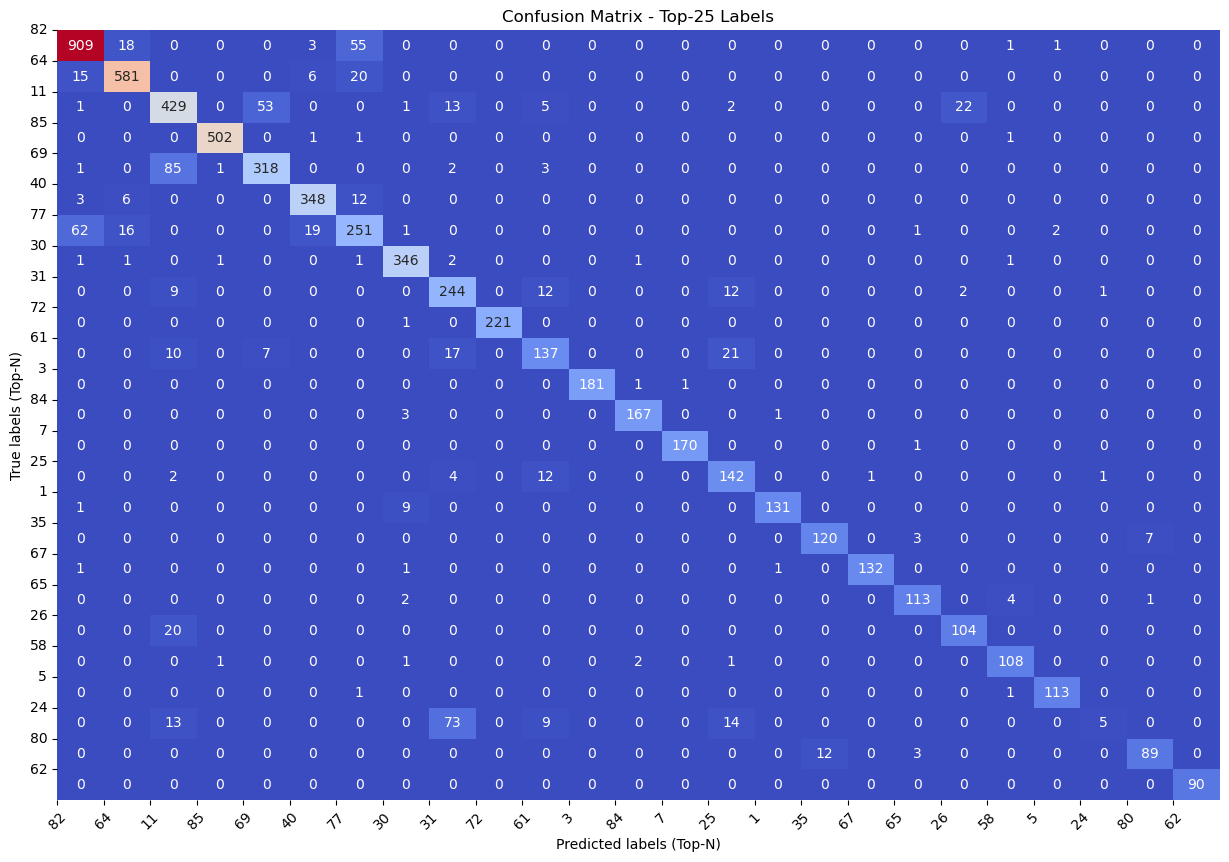

In [41]:

# Generate confusion matrix for SVM and visualize
conf_matrix_logreg = confusion_matrix(y_test, y_pred_svm)

# Step 1: Identify Top-N Labels
label_counts = np.bincount(y_test)  # Count occurrences of each label
top_n_labels_indices = np.argsort(label_counts)[::-1][:25]  # Get indices of top-N labels sorted by occurrence frequency

# Ensure indices are within bounds
top_n_labels_indices = top_n_labels_indices[top_n_labels_indices < conf_matrix_logreg.shape[0]]

# Step 2: Filter Confusion Matrix
conf_matrix_top_n = conf_matrix_logreg[top_n_labels_indices][:, top_n_labels_indices]

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix_top_n, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.xlabel('Predicted labels (Top-N)')
plt.ylabel('True labels (Top-N)')
plt.title('Confusion Matrix - Top-25 Labels')
plt.xticks(ticks=range(len(top_n_labels_indices)), labels=top_n_labels_indices, rotation=45)
plt.yticks(ticks=range(len(top_n_labels_indices)), labels=top_n_labels_indices, rotation=0)
plt.show()
